In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from easydict import EasyDict as edict
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# variational autoencoders
class Net(nn.Module):
    """
    para: the parameter of network
    """
    def __init__(self, para):
        super(Net, self).__init__()
        self.para = para
        
        # encoder init
        if self.para.conditional:
            assert self.para.num_labels>0, "num labels must >0 if conditional is true"
            self.encoder_hidden_dense = nn.Linear(self.para.input_shape+self.para.num_labels, self.para.encoder_hidden_shape)
        else:
            self.encoder_hidden_dense = nn.Linear(self.para.input_shape, self.para.encoder_hidden_shape)
            
        self.mu_dense = nn.Linear(self.para.encoder_hidden_shape, self.para.latent_space_dimension)
        self.log_sigma_dense = nn.Linear(self.para.encoder_hidden_shape, self.para.latent_space_dimension)
        
        # decoder init
        if self.para.conditional:
            self.decoder_hidden_dense = nn.Linear(self.para.latent_space_dimension+self.para.num_labels, self.para.decoder_hidden_shape)
        else:
            self.decoder_hidden_dense = nn.Linear(self.para.latent_space_dimension, self.para.decoder_hidden_shape)

        self.decoder_output_dense = nn.Linear(self.para.decoder_hidden_shape, self.para.input_shape)
        
    def encoder(self, x, c=None):
        # encoder e_h-->encoder_hidden
        if self.para.conditional:
            c = self.idx2onehot(c)
            x = torch.cat((x, c), dim=-1)

        e_h = F.relu(self.encoder_hidden_dense(x))
        mu = self.mu_dense(e_h)
        log_sigma = self.log_sigma_dense(e_h)
        return mu, log_sigma

    def decoder(self, z, c=None):
        # decoder d_h-->decoder_hidden
        if self.para.conditional:
            c = self.idx2onehot(c)
            z = torch.cat((z, c), dim=-1)
            
        d_h = F.relu(self.decoder_hidden_dense(z))
        output = torch.sigmoid(self.decoder_output_dense(d_h))
        return output

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape[0], self.para.latent_space_dimension, device=self.para.device)
        return mu + torch.exp(log_sigma/2)*eps

    def forward(self, x, c=None):
        mu, log_sigma = self.encoder(x, c=c)
        
        # constrcut sigma based on log_sigma to generate z
        z = self.sample_z(mu, log_sigma)
        output = self.decoder(z, c=c)

        return output, mu, log_sigma, z
    
    def inference(self, n=10):
        # when training finished, the latent space distribution is (0,1), so we just generate z according to torch.randn
        with torch.no_grad():
            z = torch.randn([n, self.para.latent_space_dimension], device=self.para.device)
            if self.para.conditional:
                c = torch.arange(0, 10).long().unsqueeze(1)
                c = c.to(self.para.device)
                recon_x = model.decoder(z, c)
            else:
                recon_x = model.decoder(z)

        return recon_x
    
    def idx2onehot(self, idx):

        assert torch.max(idx).item() < self.para.num_labels
        if idx.dim() == 1:
            idx = idx.unsqueeze(1)

        onehot = torch.zeros(idx.size(0), self.para.num_labels, device=self.para.device)
        onehot.scatter_(1, idx, 1)

        return onehot

In [3]:
def train(model, data_loader, epoch, para, optimizer):
    model.train()
    for batch_idx, (X, target) in enumerate(data_loader):
        X = X.view(-1, 784)
        target = target.to(para.device)
        # torch.cuda.is_available()
        X = X.to(para.device)
        optimizer.zero_grad()
        if para.conditional:
            X_sample, mu, log_sigma, z = model(X, target)
        else:
            X_sample, mu, log_sigma, z = model(X)
        # print(X_sample.shape)
        # X_sample = torch.where(X_sample > 0.5, torch.ones_like(X_sample), torch.zeros_like(X_sample))
        recon_loss = F.binary_cross_entropy(X_sample.view(-1, 28*28), X.view(-1, 28*28), reduction='sum')/para.batch_size
        kl_loss = -0.5 * torch.sum(-torch.exp(log_sigma) - mu.pow(2) + 1. + log_sigma)/para.batch_size
        loss = recon_loss + kl_loss

        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(X), len(data_loader.dataset),
              100. * batch_idx / len(data_loader), loss.item()))

In [46]:
para = edict()
para.input_shape = 784
para.num_labels = 10
para.encoder_hidden_shape = 256
para.latent_space_dimension = 8
para.decoder_hidden_shape = 256
para.batch_size = 64
para.device = torch.device("cuda")
para.conditional = True

In [17]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
data_train = datasets.MNIST(root = "/home/zeven/pycharmproject/learn/VAE/data/", transform=transform, train = True, download = True)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size = para.batch_size, shuffle = True)

data_test = datasets.MNIST(root = "/home/zeven/pycharmproject/learn/VAE/data/", transform=transform, train = False, download = True)
data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size = para.batch_size, shuffle = True)

In [47]:
model = Net(para).to(para.device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
epochs=50
for epoch in range(1, epochs+1):
    train(model, data_loader_train, epoch, para, optimizer)

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.789429
Train Epoch: 1 [6400/60000 (11%)]	Loss: -5709.018555
Train Epoch: 1 [12800/60000 (21%)]	Loss: -7499.951660
Train Epoch: 1 [19200/60000 (32%)]	Loss: -9884.646484
Train Epoch: 1 [25600/60000 (43%)]	Loss: -11429.527344
Train Epoch: 1 [32000/60000 (53%)]	Loss: -12182.111328
Train Epoch: 1 [38400/60000 (64%)]	Loss: -13566.706055
Train Epoch: 1 [44800/60000 (75%)]	Loss: -13348.797852
Train Epoch: 1 [51200/60000 (85%)]	Loss: -14091.114258
Train Epoch: 1 [57600/60000 (96%)]	Loss: -15264.900391
Train Epoch: 2 [0/60000 (0%)]	Loss: -14929.215820
Train Epoch: 2 [6400/60000 (11%)]	Loss: -15146.365234
Train Epoch: 2 [12800/60000 (21%)]	Loss: -15345.499023
Train Epoch: 2 [19200/60000 (32%)]	Loss: -15610.755859
Train Epoch: 2 [25600/60000 (43%)]	Loss: -15118.907227
Train Epoch: 2 [32000/60000 (53%)]	Loss: -15486.538086
Train Epoch: 2 [38400/60000 (64%)]	Loss: -15926.204102
Train Epoch: 2 [44800/60000 (75%)]	Loss: -15769.333984
Train Epoch: 2 [51200/60000 

<Figure size 432x288 with 0 Axes>

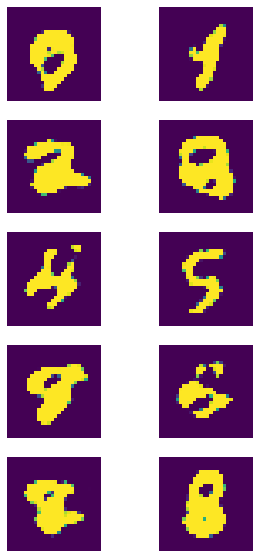

In [48]:
# x = inference(model, n=10, para=para)
plt.figure()
plt.figure(figsize=(5, 10))
x = model.inference(n=10)
x = x.cpu().numpy()
for p in range(10):
    plt.subplot(5, 2, p+1)
    plt.imshow(x[p].reshape(28, 28))
    plt.axis('off')
    plt.savefig("sample-{}-{}.png".format(para.latent_space_dimension, para.conditional))

In [42]:
# latent space
import pandas as pd
model.eval()
latent = np.zeros((60000, 2))
label = np.zeros((60000, ))
with torch.no_grad():
    for batch_idx, (X, target) in enumerate(data_loader_train):
        X = X.view(-1, 784)
        target = target.to(para.device)
        # torch.cuda.is_available()
        X = X.to(para.device)
        if para.conditional:
            X_sample, mu, log_sigma, z = model(X, target)
        else:
            X_sample, mu, log_sigma, z = model(X)
        
        latent[batch_idx*64:(batch_idx+1)*64] = z.cpu().numpy()
        label[batch_idx*64:(batch_idx+1)*64] = target.cpu().numpy()

In [43]:
res = pd.DataFrame(columns=["x", "y", "label"])
res["x"] = latent[:, 0]
res["y"] = latent[:, 1]
res["label"] = label

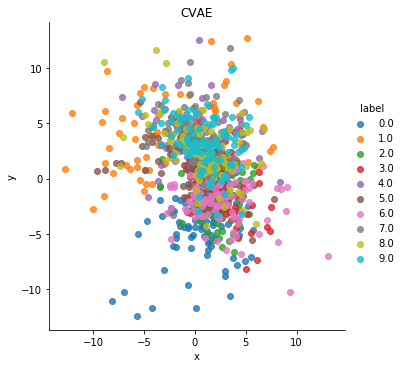

In [45]:
g = sns.lmplot(
    x='x', y='y', hue='label', data=res.groupby('label').head(100),
    fit_reg=False, legend=True)
plt.title("CVAE")
g.savefig("latent_space_conditional.png", dpi=300)